<a href="https://colab.research.google.com/github/AmrElmowafy1977/AmrElmowafy1977/blob/main/Disaster__Tweets_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import re

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [7]:
from sklearn.model_selection import train_test_split

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [11]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import constant


In [15]:
from tensorflow.keras.optimizers import Adam

In [23]:
import tensorflow as tf

In [24]:
import nltk

In [25]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
stop = set(stopwords.words('english'))

#Loading Data

In [27]:
df_train = pd.read_csv("/content/train (2).csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
df_test = pd.read_csv("/content/test (1).csv")
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [29]:
print(f"There are {df_train.shape[0]} rows and {df_train.shape[1]} columns. ")

There are 7613 rows and 5 columns. 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


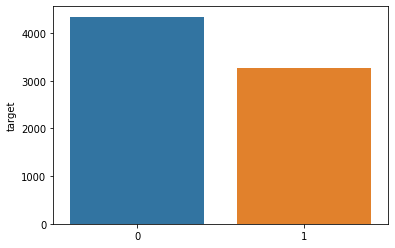

In [30]:
class_dist = df_train.target.value_counts()
sns.barplot(class_dist.index,class_dist)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


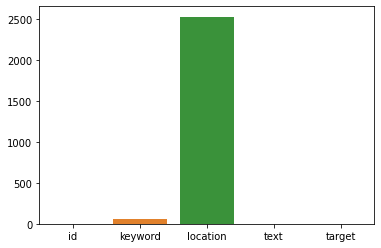

In [31]:
# Misssing vs Non Missing
# 'keyword' & 'location' columns have missing values. Looks like 'location' column is very dirty so lets not use it. Lets also ignore 'keyword' column for now.
null_vals = df_train.isnull().sum()
sns.barplot(null_vals.index,null_vals)

#Cleaning the Dataset

In [32]:
def remove_spec(text):
    text = re.sub('<.*?>+', '', text)
    text = text.lower()
    return text

In [33]:

def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

#Removing URL

In [34]:
def remove_urls(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    return text

In [36]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x : remove_punctuation(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_urls(x))

df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_spec(x))

In [38]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
def create_corpus(dataset):
    corpus = []
    for review in tqdm(dataset['cleaned_text']):
        words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) & (word not in stop) ]
        corpus.append(words)

    return corpus

corpus = create_corpus(df_train)

100%|██████████| 7613/7613 [00:01<00:00, 6635.26it/s]


# Creating Embedding

In [40]:
MAX_LEN = 20 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [41]:
# Unique words present
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 16883


In [48]:
MAX_LEN = 20 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [49]:
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 16883


In [50]:
num_words=len(word_index)+1


for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 16883/16883 [00:00<00:00, 1046159.36it/s]


In [51]:
# We need sequential model to process sequence of text data
model=Sequential()

In [52]:
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)

In [53]:
# Adding Embedding Layer
model.add(embedding)

In [54]:
# Drops 40% of entire row
model.add(SpatialDropout1D(0.4))

In [55]:
# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

In [56]:
# Decide what we are going to output Dense(units, activation function)
model.add(Dense(1, activation='sigmoid'))

In [57]:
# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1688400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,730,705
Trainable params: 42,305
Non-trainable params: 1,688,400
_________________________________________________________________


In [59]:
X_train,X_test,y_train,y_test = train_test_split(corpus_pad, df_train['target'].values, test_size = 0.25, random_state = 0 )

In [61]:
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

print('Shape of train',y_train.shape)
print("Shape of Validation ",y_test.shape)

Shape of train (5709, 20)
Shape of Validation  (1904, 20)
Shape of train (5709,)
Shape of Validation  (1904,)


In [63]:
history=model.fit(X_train,y_train,batch_size=32,epochs=70,validation_data=(X_test,y_test),verbose=2)

Epoch 1/70
179/179 - 5s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6805 - val_accuracy: 0.5814 - 5s/epoch - 26ms/step
Epoch 2/70
179/179 - 4s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6803 - val_accuracy: 0.5814 - 4s/epoch - 20ms/step
Epoch 3/70
179/179 - 4s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6803 - val_accuracy: 0.5814 - 4s/epoch - 20ms/step
Epoch 4/70
179/179 - 4s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6802 - val_accuracy: 0.5814 - 4s/epoch - 20ms/step
Epoch 5/70
179/179 - 3s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6807 - val_accuracy: 0.5814 - 3s/epoch - 19ms/step
Epoch 6/70
179/179 - 4s - loss: 0.6845 - accuracy: 0.5666 - val_loss: 0.6804 - val_accuracy: 0.5814 - 4s/epoch - 20ms/step
Epoch 7/70
179/179 - 4s - loss: 0.6843 - accuracy: 0.5666 - val_loss: 0.6802 - val_accuracy: 0.5814 - 4s/epoch - 20ms/step
Epoch 8/70
179/179 - 3s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6807 - val_accuracy: 0.5814 - 3s/epoch - 20ms/step
Epoch 9/70
179/1